In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../data/cleaned_responses.csv")

print("Original dataset shape:", df.shape)
print("Target variable distribution:")
print(df['diabetes_diagnosed'].value_counts())
print(f"Diabetes prevalence: {(df['diabetes_diagnosed'].sum() / len(df)) * 100:.2f}%")


Original dataset shape: (314, 14)
Target variable distribution:
diabetes_diagnosed
0    211
1    103
Name: count, dtype: int64
Diabetes prevalence: 32.80%


In [2]:
# Feature selection and preparation

feature_cols = ['gender', 'pregnancies', 'age', 'glucose', 'blood_pressure', 
                'weight', 'height', 'insulin', 'bmi', 'physically_active', 
                'smoking', 'junk_food', 'family_history']

X = df[feature_cols].copy()
y = df['diabetes_diagnosed'].copy()

# Check correlation with target variable
print("\nCorrelation with target variable:")
correlations = X.corrwith(y).sort_values(ascending=False)
print(correlations)



Correlation with target variable:
blood_pressure       0.802786
age                  0.713982
glucose              0.568363
weight               0.559851
height               0.341301
family_history       0.334295
smoking              0.295420
pregnancies          0.272878
bmi                  0.230439
physically_active    0.110218
gender               0.078578
insulin              0.001255
junk_food           -0.052927
dtype: float64


In [3]:
# Data preparation and train-test split

complete_data = df[feature_cols + ['diabetes_diagnosed']].dropna()

X = complete_data[feature_cols].copy()
y = complete_data['diabetes_diagnosed'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"Training set diabetes prevalence: {(y_train.sum() / len(y_train)) * 100:.2f}%")

print(f"\nTest set target distribution:")
print(y_test.value_counts())
print(f"Test set diabetes prevalence: {(y_test.sum() / len(y_test)) * 100:.2f}%")



Training set target distribution:
diabetes_diagnosed
0    169
1     82
Name: count, dtype: int64
Training set diabetes prevalence: 32.67%

Test set target distribution:
diabetes_diagnosed
0    42
1    21
Name: count, dtype: int64
Test set diabetes prevalence: 33.33%


In [4]:
# Random Forest Model Training

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='f1', n_jobs=1, verbose=1
)

print("Fitting Random Forest models with different parameter combinations...")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)


Fitting Random Forest models with different parameter combinations...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.9508


,n_estimators,200
,criterion,'gini'
,max_depth,5
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
# Model Evaluation

y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nRandom Forest Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

print("\nCross-validation scores:")
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1')
print(f"CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Random Forest Model Performance Metrics:
Accuracy: 0.9841
Precision: 1.0000
Recall: 0.9524
F1-Score: 0.9756
AUC-ROC: 0.9728

Confusion Matrix:
[[42  0]
 [ 1 20]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.95      0.98        21

    accuracy                           0.98        63
   macro avg       0.99      0.98      0.98        63
weighted avg       0.98      0.98      0.98        63


Cross-validation scores:
CV F1-Score: 0.9508 (+/- 0.0624)



Feature Importance (Random Forest):
              feature  importance
4      blood_pressure    0.331028
2                 age    0.204566
5              weight    0.131860
3             glucose    0.121697
7             insulin    0.057429
8                 bmi    0.052774
6              height    0.035195
12     family_history    0.022937
9   physically_active    0.015643
1         pregnancies    0.012550
10            smoking    0.007088
0              gender    0.004030
11          junk_food    0.003202


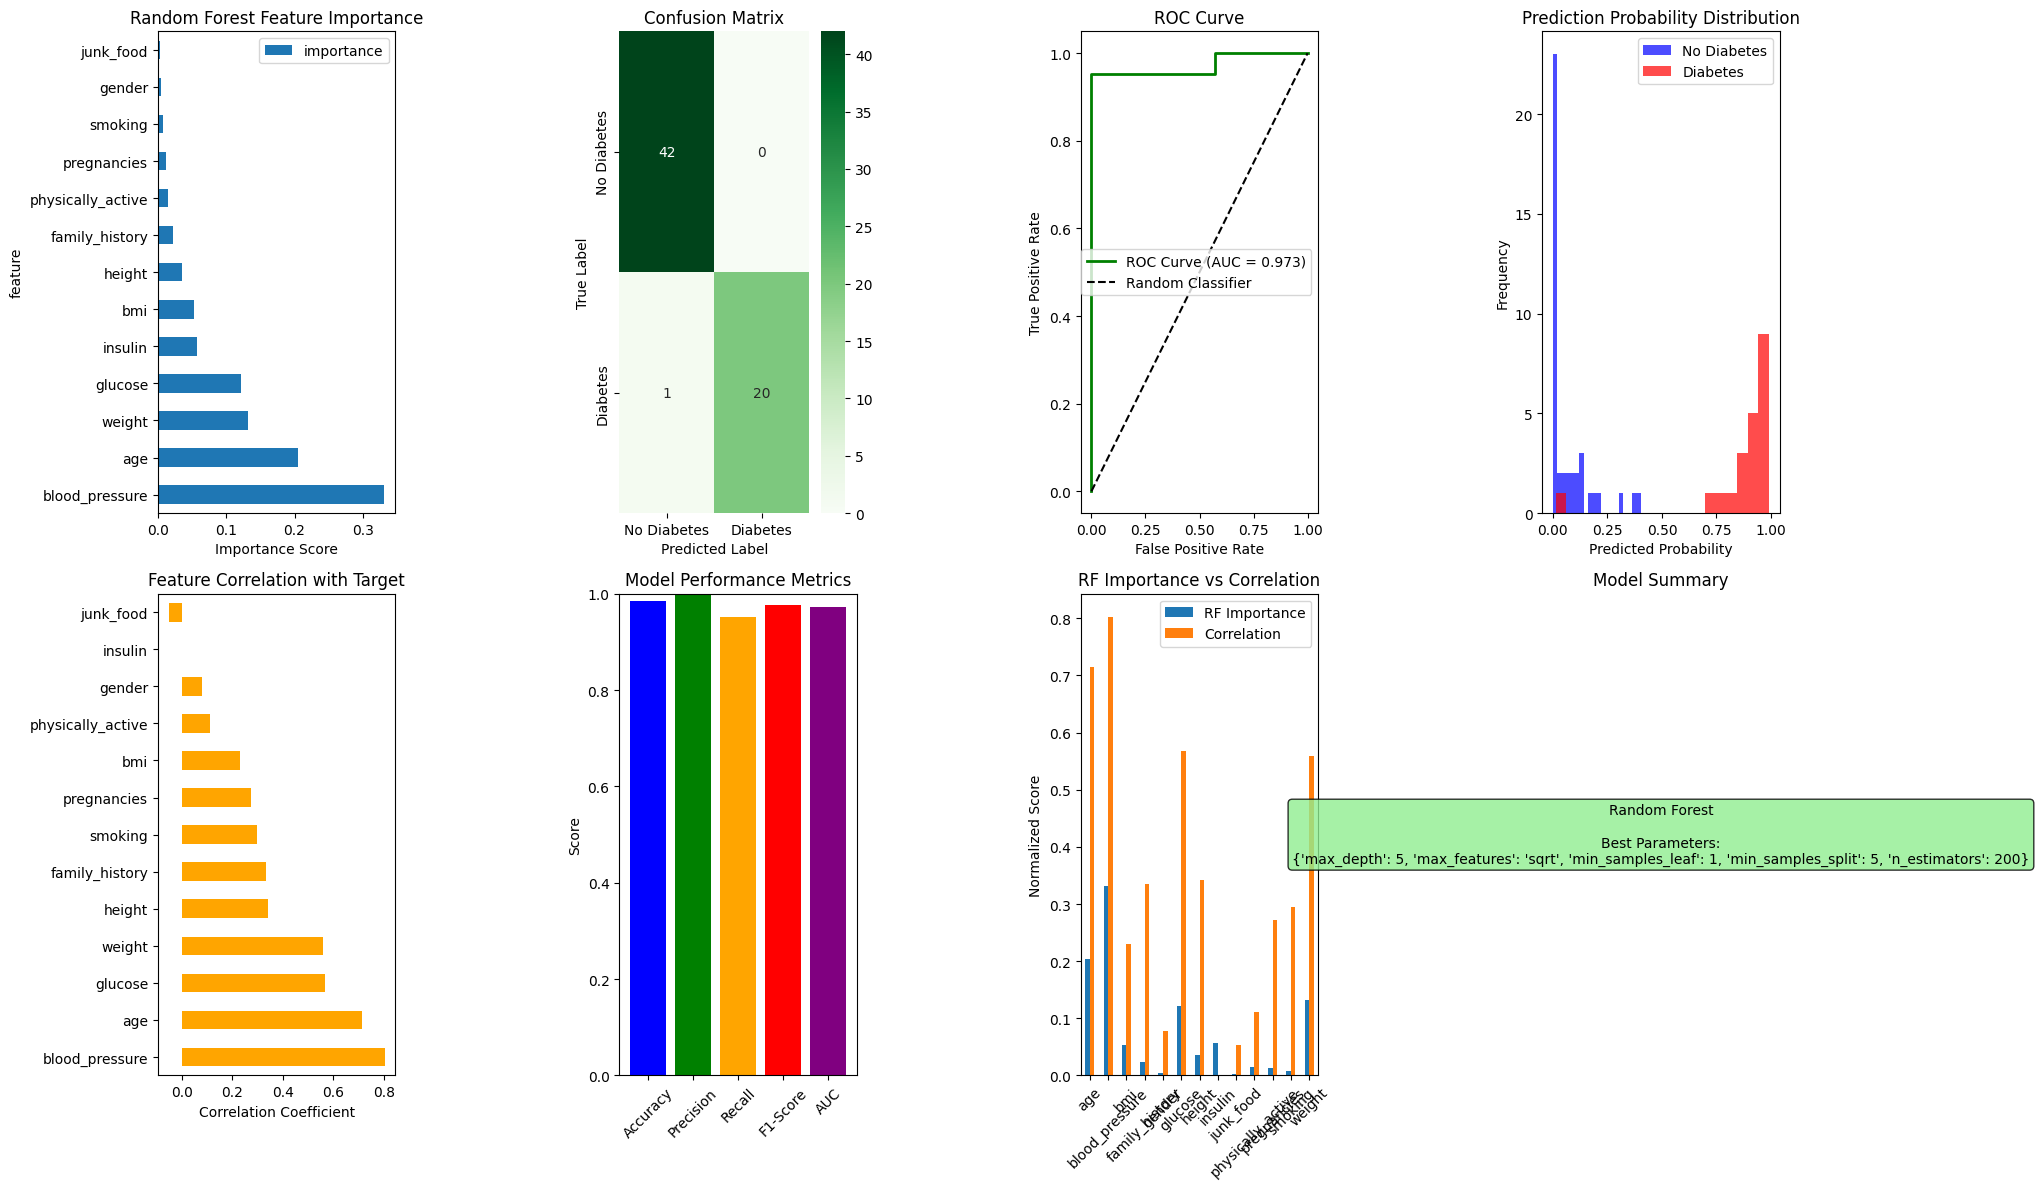


Random Forest visualizations completed.


In [6]:
# Feature Importance Analysis

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_rf.feature_importances_
})

feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)

plt.figure(figsize=(20, 12))

# 1. Feature Importance Plot
plt.subplot(2, 4, 1)
feature_importance.plot(x='feature', y='importance', kind='barh', ax=plt.gca())
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')

# 2. Confusion Matrix Heatmap
plt.subplot(2, 4, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 3. ROC Curve
plt.subplot(2, 4, 3)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='green', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# 4. Prediction Probability Distribution
plt.subplot(2, 4, 4)
plt.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='No Diabetes', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Diabetes', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.legend()

# 5. Feature Correlation with Target
plt.subplot(2, 4, 5)
correlations.plot(kind='barh', color='orange')
plt.title('Feature Correlation with Target')
plt.xlabel('Correlation Coefficient')

# 6. Model Performance Summary
plt.subplot(2, 4, 6)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [accuracy, precision, recall, f1, auc]
colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.bar(metrics, values, color=colors)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# 7. Feature Importance vs Correlation Comparison
plt.subplot(2, 4, 7)
importance_norm = feature_importance.set_index('feature')['importance']
corr_norm = correlations.abs()
comparison_df = pd.DataFrame({
    'RF Importance': importance_norm,
    'Correlation': corr_norm
}).fillna(0)
comparison_df.plot(kind='bar', ax=plt.gca())
plt.title('RF Importance vs Correlation')
plt.ylabel('Normalized Score')
plt.xticks(rotation=45)

# 8. Learning Curve
plt.subplot(2, 4, 8)
plt.text(0.5, 0.5, f'Random Forest\n\nBest Parameters:\n{grid_search.best_params_}', 
         ha='center', va='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
plt.axis('off')
plt.title('Model Summary')

plt.tight_layout()
plt.show()

print("\nRandom Forest visualizations completed.")


In [7]:
# Save the trained model and scaler
model_path = "/Users/91life/Desktop/diabetes-project/models/"

os.makedirs(model_path, exist_ok=True)

# Save Random Forest model
joblib.dump(best_rf, f"{model_path}random_forest_model.pkl")

# Save scaler (Random Forest doesn't need scaling, but we'll save a dummy scaler for consistency)
from sklearn.preprocessing import StandardScaler
dummy_scaler = StandardScaler()
dummy_scaler.fit(X_train)  # Fit on training data
joblib.dump(dummy_scaler, f"{model_path}scaler_rf.pkl")

print(f"Random Forest model saved to: {model_path}random_forest_model.pkl")
print(f"Random Forest scaler saved to: {model_path}scaler_rf.pkl")


Random Forest model saved to: /Users/91life/Desktop/diabetes-project/models/random_forest_model.pkl
Random Forest scaler saved to: /Users/91life/Desktop/diabetes-project/models/scaler_rf.pkl
